In [1]:
# Import database dependencies
from sqlalchemy import inspect, create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import config as creds

# Import Pandas and matplotlib dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Import scikit packages
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
import sklearn.datasets as datasets
# For splitting of data into train and test set
from sklearn.model_selection import train_test_split
# Metrics for Evaluation of model Accuracy and F1-score
from sklearn.metrics  import f1_score,accuracy_score
import sklearn.metrics as metrics

In [2]:
#!pip install psycopg2

In [3]:
#!pip install psycopg2-binary 

In [4]:
# Create engine
engine = create_engine(f'postgresql://{creds.PGUSER}:{creds.PGPASSWORD}@{creds.PGHOST}:5432/{creds.PGDATABASE}')

In [5]:
# Create our session (link) from Python to the DB
session = Session(bind=engine.connect())

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# List tables in database
inspect(engine).get_table_names()

['ave_wage_indexing',
 'welfare_education',
 'cpi_inflation_rate',
 'crime_rate',
 'economic_features_full',
 'economic_features',
 'divorce_rate',
 'homeownership_rate',
 'min_wage_effective',
 'poverty_rates',
 'unemployment_rate']

In [8]:
# List columns in a specific table ('min_wage')
[column['name'] for column in inspect(engine).get_columns('economic_features')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'avg_wage_index',
 'poverty_rate']

In [9]:
# Defining function that takes in a table name and outputs a dataframe
def db_reader(tablename):
    table_df = pd.read_sql_table(f'{tablename}', engine)
    return table_df

In [10]:
# Reading a database table into a dataframe
econ_features_full = db_reader('economic_features_full')
econ_features_full.head()

,year,state,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,avg_wage_index,poverty_rate
0,1970,National,203.302,56456.0,18738.8,363.5,NaN,3.50,NaN,1.382353,38.8,6186.24,17.18
1,1971,National,205.515,63469.0,27364.3,396.0,NaN,3.75,NaN,1.382353,40.5,6497.08,17.05
2,1972,National,207.752,71351.0,30594.3,401.0,NaN,4.00,NaN,1.623529,41.8,7133.80,16.12
3,1973,National,210.013,75849.0,28944.9,417.4,NaN,4.25,NaN,1.623529,44.4,7580.16,15.13
4,1974,National,212.299,81440.0,34816.4,461.1,NaN,4.50,NaN,1.623529,49.3,8030.76,15.86


In [11]:
# plt.scatter(econ_features_full.avg_wage_index,econ_features_full.poverty_rate )
# plt.xlabel('avg_wage_index')
# plt.ylabel('poverty_rate')
# plt.show()

# xlabel = independent variable
# ylabel = target variable that we want to predict 

In [21]:
# Drop the non-beneficial columns
model_df = econ_features_full.drop(columns=["state"], axis=1).dropna()
model_df.head()

,year,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,avg_wage_index,poverty_rate
6,1976,216.945,107290.0,72155.2,467.8,7.786562,5.0,7.79,2.226667,56.9,9226.48,14.10
7,1977,219.307,115893.0,83417.8,475.9,7.132505,5.1,7.13,2.226667,60.6,9779.44,13.92
8,1978,221.694,128541.0,81037.9,497.8,6.134198,5.2,6.13,2.226667,65.2,10556.03,13.43
9,1979,224.107,140169.0,83691.3,548.9,5.923827,5.3,5.92,2.910000,72.6,11479.46,13.33
10,1980,226.546,153686.0,108251.7,596.6,7.255717,5.2,7.26,3.110196,82.4,12513.46,14.65


In [50]:
# Define X and y variables
X = model_df.drop(["poverty_rate"], axis=1)#.values.reshape(-1, 1)
y = model_df["poverty_rate"]



In [51]:
X.head()

,year,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,avg_wage_index
6,1976,216.945,107290.0,72155.2,467.8,7.786562,5.0,7.79,2.226667,56.9,9226.48
7,1977,219.307,115893.0,83417.8,475.9,7.132505,5.1,7.13,2.226667,60.6,9779.44
8,1978,221.694,128541.0,81037.9,497.8,6.134198,5.2,6.13,2.226667,65.2,10556.03
9,1979,224.107,140169.0,83691.3,548.9,5.923827,5.3,5.92,2.910000,72.6,11479.46
10,1980,226.546,153686.0,108251.7,596.6,7.255717,5.2,7.26,3.110196,82.4,12513.46


In [52]:
X.shape

(1594, 11)

In [53]:
model_df.dtypes

year                              int64
population_million              float64
education_million               float64
welfare_million                 float64
crime_rate                      float64
unemployment_rate               float64
divorce_rate_per_1000_people    float64
homeownership_rate              float64
minimum_wage_effective          float64
cpi_average                     float64
avg_wage_index                  float64
poverty_rate                    float64
dtype: object

In [54]:
# Standardize data
import sklearn.preprocessing as preprocessing

std = preprocessing.StandardScaler()
# X is a matrix
std.fit(X)
X_std = std.transform(X)

In [55]:
# Split the dataset into training and testing sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
    y, random_state=1)

In [56]:
# Create a model with scikit-learn
model = LinearRegression()

In [57]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [61]:
# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)
print(X.shape)


# for regression we use R2 score and MAE(mean absolute error)
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# print(mean_absolute_error(y_test,y_pred))
# print(mean_absolute_error(y_test,y_pred))

(1594,)
(1594, 11)


ValueError: x and y must be the same size

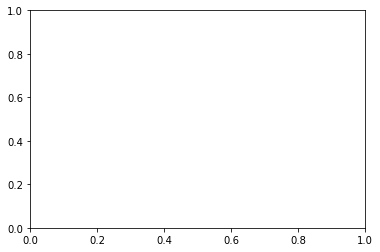

In [36]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [59]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-8.19432789e-01 -7.47694436e-02  2.32125315e-05 -1.51410363e-05
  4.12829603e-03  1.07730287e+00 -2.32657306e+00 -1.68965782e-01
 -8.37761955e-01  7.81550727e-02  2.48173477e-04]
1649.9479309010358
